In [1]:
from tqdm.auto import tqdm

ast = []
with open("../data/py150/python100k_train.json") as json_file:
    for line in tqdm(json_file):
        ast.append(line)

0it [00:00, ?it/s]

In [2]:
class ASTNode:
    def __init__(self, idx, node_type, value):
        self.idx = idx
        self.type = node_type
        self.value = value
        self.children = []

    def __repr__(self):
        return f"ID:{self.idx}, {self.type}:{self.value}, children:{self.children}"

In [3]:
import json


def create_ast_node(node_idx, node_dict, node_arr):
    node_type = node_dict["type"]
    node_value = node_dict.get("value", None)
    if node_value == "None":
        node_value = None
    node = ASTNode(node_idx, node_type, node_value)
    for child_node_idx in node_dict.get("children", []):
        child_node_dict = node_arr[child_node_idx]
        node.children.append(create_ast_node(child_node_idx, child_node_dict, node_arr))
    return node


def ast_str2tree(ast_str):
    node_arr = json.loads(ast_str)
    root = create_ast_node(0, node_arr[0], node_arr)
    return root

In [4]:
def ast_walk(root):
    yield root
    if len(root.children) == 0:
        return
    for child_node in root.children:
        for node in ast_walk(child_node):
            yield node


# for node in ast_walk(sample_tree):
#     print(node.type)

In [5]:
def casing_match(token):

    lower_camel = r"^[a-z]+([A-Z][a-z0-9]+)+$"
    upper_camel = r"^[A-Z][a-z]+([A-Z][a-z0-9]+)*$"
    snake = r"[a-z0-9]*_*(_[a-z0-9]*)+_*"
    lower = r"^[a-z][a-z0-9]*$"
    upper = r"^[A-Z][A-Z0-9]*$"

    if re.match(snake, token):
        return "snake"
    elif re.match(upper_camel, token):
        return "upper_camel"
    elif re.match(lower_camel, token):
        return "lower_camel"
    elif re.match(lower, token):
        return "lower"
    elif re.match(upper, token):
        return "upper"
    else:
        return None

In [48]:
import re

IDENTIFIER_AST_NODE_TYPES = [
    "NameParam",
    "NameStore",
    "attr",
    "identifier",
    "keyword",
    "kwarg",
    "vararg",
    "FunctionDef",
    "ClassDef",
]


def count_identifier(node, results):
    total_result = results[0]
    var_result = results[1]
    class_result = results[2]
    func_result = results[3]
    if node.type in IDENTIFIER_AST_NODE_TYPES:
        if node.type == "ClassDef":
            result = class_result
        elif node.type == "FunctionDef":
            result = func_result
        else:
            result = var_result

        result["total"] = result.get("total", 0) + 1
        total_result["total"] = total_result.get("total", 0) + 1
        token = node.value

        if token == None:
            return

        casing = casing_match(token)

        if casing == "snake":
            result["snake"] = result.get("snake", 0) + 1
            total_result["snake"] = total_result.get("snake", 0) + 1
        elif casing == "lower":
            result["lower"] = result.get("lower", 0) + 1
            total_result["lower"] = total_result.get("lower", 0) + 1
        elif casing == "upper":
            result["upper"] = result.get("upper", 0) + 1
            total_result["upper"] = total_result.get("upper", 0) + 1
        elif casing == "lower_camel":
            result["lower_camel"] = result.get("lower_camel", 0) + 1
            total_result["lower_camel"] = total_result.get("lower_camel", 0) + 1
        elif casing == "upper_camel":
            result["upper_camel"] = result.get("upper_camel", 0) + 1
            total_result["upper_camel"] = total_result.get("upper_camel", 0) + 1
        else:
            result["none_of_these"] = result.get("none_of_these", 0) + 1
            total_result["none_of_these"] = total_result.get("none_of_these", 0) + 1

In [49]:
def identifier_count_to_proportion(result):
    proportion_results = {}
    total_case_count = {}
    id_types = result.keys()
    for id_type in id_types:
        id_type_result = result[id_type]
        proportion_result = {}
        for case in id_type_result.keys():
            if case == "total":
                continue
            proportion_result[case] = (
                round(id_type_result[case] / id_type_result["total"], 6)
                if id_type_result["total"] > 0
                else 0
            )
        proportion_results[id_type] = proportion_result

    return proportion_results.copy()

In [160]:
def get_docstring(node):
    doc_strs = []
    for body_node in node.children:
        if body_node.type != "body":
            continue
        for expr_node in body_node.children:
            if expr_node.type != "Expr":
                continue
            for str_node in expr_node.children:
                doc_str = str_node.value
                if doc_str == None:
                    continue
                doc_strs.append(doc_str)
    return doc_strs


def count_method_with_docstring(node, result):
    _id = node.type
    if _id == "FunctionDef":
        ds = get_docstring(node)
        if ds:
            result["func_docstr"] = result.get("func_docstr", 0) + 1


def count_docstring(node, doc_result):
    doc_strs = get_docstring(node)
    if not doc_strs:
        return
    for doc_str in doc_strs:
        doc_result["lines"] += len(doc_str.split("\n"))
        doc_result["len"] += len(doc_str)

    _id = node.type
    if _id == "FunctionDef":
        doc_result["func_docstr_count"] += 1


def extract_metric_from_ast(root):
    result = {}
    id_result_template = {
        "total": 0,
        "snake": 0,
        "lower": 0,
        "upper": 0,
        "lower_camel": 0,
        "upper_camel": 0,
        "none_of_these": 0,
    }
    id_results = [
        id_result_template.copy(),
        id_result_template.copy(),
        id_result_template.copy(),
        id_result_template.copy(),
    ]
    doc_result = {
        "lines":0,
        "len":0,
        "count":0,
        "func_docstr_count":0,
    }
    for node in ast_walk(root):
        # Count Identifiers
        count_identifier(node, id_results)
        # Count Docstring
        count_docstring(node, doc_result)

    id_result = identifier_count_to_proportion(
        {
            "total": id_results[0],
            "var": id_results[1],
            "class": id_results[2],
            "func": id_results[3],
        }
    )
    result["id"] = id_result.copy()
    result["doc_str"] = doc_result.copy()

    return result.copy()


# sample_ast_tree = ast_str2tree(ast[18])
# extract_metric_from_ast(sample_ast_tree)

In [161]:
data_metrics = []

for ast_str in tqdm(ast):
    ast_tree = ast_str2tree(ast_str)
    data_metric = extract_metric_from_ast(ast_tree)
    data_metrics.append(data_metric)

100%|██████████| 100000/100000 [08:11<00:00, 203.35it/s]


In [162]:
data_metrics[0]

{'id': {'total': {'snake': 0.0,
   'lower': 1.0,
   'upper': 0.0,
   'lower_camel': 0.0,
   'upper_camel': 0.0,
   'none_of_these': 0.0},
  'var': {'snake': 0.0,
   'lower': 1.0,
   'upper': 0.0,
   'lower_camel': 0.0,
   'upper_camel': 0.0,
   'none_of_these': 0.0},
  'class': {'snake': 0,
   'lower': 0,
   'upper': 0,
   'lower_camel': 0,
   'upper_camel': 0,
   'none_of_these': 0},
  'func': {'snake': 0,
   'lower': 0,
   'upper': 0,
   'lower_camel': 0,
   'upper_camel': 0,
   'none_of_these': 0}},
 'doc_str': {'lines': 0, 'len': 0, 'count': 0, 'func_docstr_count': 0}}

In [12]:
import re

from tqdm import tqdm
import pandas as pd

In [13]:
train_file_name = "../data/py150/py150_files/python100k_train.txt"
eval_file_name = "../data/py150/py150_files/python50k_eval.txt"


def read_train_data(file_name, batch_size=None):
    file_names = []
    with open(file_name, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break

            file_names += [line.strip()]

            if batch_size and len(file_names) >= batch_size:
                break

    return file_names


def read_file_to_string(filename):
    f = open(filename, "rb")
    s = ""
    try:
        s = f.read()
    except:
        print(filename)
    f.close()
    return s.decode(errors="replace")


train_data = read_train_data(train_file_name)

In [14]:
def count_comments(input_code):
    comment = r"#.*"
    search = re.findall(comment, input_code)
    comment_len = 0
    for comment in search:
        comment_len += len(comment)
    return len(search), comment_len


def create_df(data):
    data_df = pd.DataFrame(data, columns=["file_name"])

    script_file_name_regex = re.compile(r"data/([^/]+)/([^/]+)/.+")

    usernames = []
    repos = []
    py_scripts = []
    comments = []
    comment_lens = []
    comment_dens = []
    line_counts = []

    for file_name in tqdm(data_df["file_name"]):

        match = script_file_name_regex.search(file_name)
        if not match:
            print(file_name)

        username = match.group(1)
        repo_name = match.group(2)

        file_string = read_file_to_string(f"../data/py150/py150_files/{file_name}")
        line_count = len(file_string.split("\n"))

        comment_count, comment_len = count_comments(file_string)
        comment_den = round(comment_count / line_count, 6) if line_count > 0 else 0

        usernames += [username]
        repos += [repo_name]
        py_scripts += [file_string]
        comments += [comment_count]
        comment_lens += [comment_len]
        comment_dens += [comment_den]
        line_counts += [line_count]

    data_df["user_name"] = usernames
    data_df["repo_name"] = repos
    data_df["py_script"] = py_scripts
    data_df["comment"] = comments
    data_df["comment_len"] = comment_lens
    data_df["comment_den"] = comment_dens
    data_df["line_count"] = line_counts

    return data_df

In [15]:
train_data_df = create_df(train_data)

100%|██████████| 100000/100000 [00:35<00:00, 2836.58it/s]


In [163]:
len(data_metrics)

100000

In [164]:
train_data_df["data_metric"] = data_metrics

In [165]:
train_repo_df = train_data_df.apply(
    lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1
)
train_data_df["user/repo"] = train_repo_df

In [166]:
watch_count = pd.read_csv("../data/watch_count_public_data.csv")
watch_count = watch_count.rename(columns={"repo_name": "user/repo"}).drop(
    columns="Record Count"
)

In [167]:
train_data_df_wc = train_data_df.join(
    watch_count.set_index("user/repo"), on="user/repo"
)
train_data_df_wc["watch_count"].size, train_data_df_wc["watch_count"].isna().sum()

(100000, 21630)

In [168]:
train_plot_df = train_data_df_wc.dropna(subset=["watch_count"])
# train_plot_df = train_plot_df[train_plot_df["watch_count"] > 10]
# train_plot_df

In [169]:
plot_data_metrics = train_plot_df["data_metric"].tolist()
watch_counts = train_plot_df["watch_count"].tolist()

In [170]:
import numpy as np

In [171]:
watch_count_arr = np.array(watch_counts)

In [172]:
watch_count_arr > 10

array([ True,  True, False, ...,  True, False, False])

In [173]:
import matplotlib.pyplot as plt

In [174]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# kmeans.labels_

# # kmeans.predict([[0, 0], [12, 3]])

# kmeans.cluster_centers_

# kmeans.labels_

# style_1_idx = kmeans.labels_ == 0
# style_2_idx = kmeans.labels_ == 1


# #Plotting the results
# plt.scatter(X[style_1_idx][:,0] , X[style_1_idx][:,1] , color = 'red')
# plt.scatter(X[style_2_idx][:,0] , X[style_2_idx][:,1] , color = 'blue')
# plt.show()

In [175]:
# Plotting the results
thresh = 300

pop_idx = watch_count_arr >= thresh
non_pop_idx = watch_count_arr < thresh

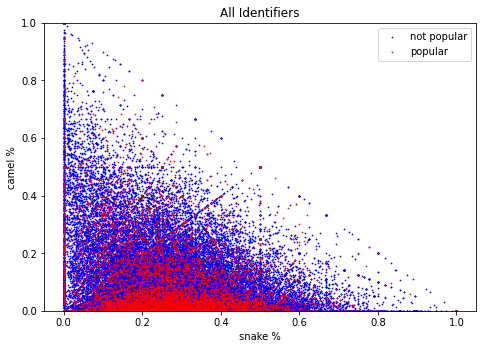

In [203]:
id_type = "total"
result = map(
    lambda _dict: [
        _dict["id"][id_type]["snake"],
        _dict["id"][id_type]["lower_camel"] + _dict["id"][id_type]["upper_camel"],
    ],
    plot_data_metrics,
)
X = np.array(list(result))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(
    X[non_pop_idx][:, 0], X[non_pop_idx][:, 1], 0.5, color="blue", label="not popular"
)
ax.scatter(X[pop_idx][:, 0], X[pop_idx][:, 1], 0.5, color="red", label="popular")
ax.legend()
ax.set_title(f"All Identifiers")
ax.set_xlabel("snake %")
ax.set_ylabel("camel %")

plt.show()
fig.savefig(f"{id_type}_id.jpg", dpi=300,bbox_inches='tight')

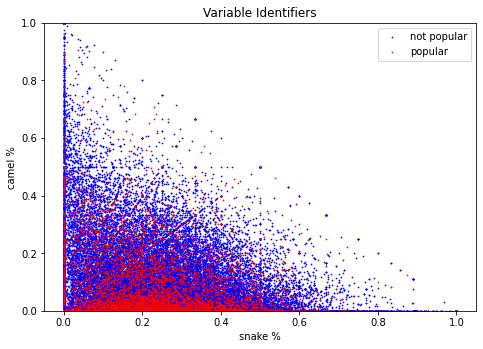

In [202]:
id_type = "var"
result = map(
    lambda _dict: [
        _dict["id"][id_type]["snake"],
        _dict["id"][id_type]["lower_camel"] + _dict["id"][id_type]["upper_camel"],
    ],
    plot_data_metrics,
)
X = np.array(list(result))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(
    X[non_pop_idx][:, 0], X[non_pop_idx][:, 1], 0.5, color="blue", label="not popular"
)
ax.scatter(X[pop_idx][:, 0], X[pop_idx][:, 1], 0.5, color="red", label="popular")
ax.legend()
ax.set_title(f"Variable Identifiers")
ax.set_xlabel("snake %")
ax.set_ylabel("camel %")

plt.show()
fig.savefig(f"{id_type}_id.jpg", dpi=300,bbox_inches='tight')

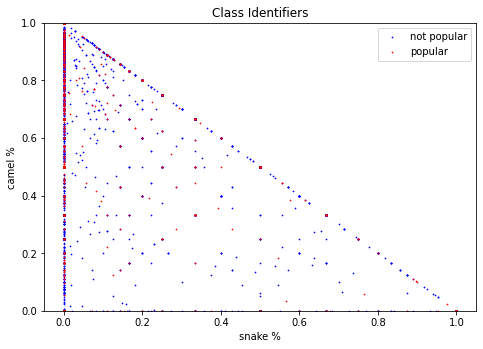

In [201]:
id_type = "class"
result = map(
    lambda _dict: [
        _dict["id"][id_type]["snake"],
        _dict["id"][id_type]["lower_camel"] + _dict["id"][id_type]["upper_camel"],
    ],
    plot_data_metrics,
)
X = np.array(list(result))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(
    X[non_pop_idx][:, 0], X[non_pop_idx][:, 1], 0.5, color="blue", label="not popular"
)
ax.scatter(X[pop_idx][:, 0], X[pop_idx][:, 1], 0.5, color="red", label="popular")
ax.legend()
ax.set_title(f"Class Identifiers")
ax.set_xlabel("snake %")
ax.set_ylabel("camel %")

plt.show()
fig.savefig(f"{id_type}_id.jpg", dpi=300,bbox_inches='tight')

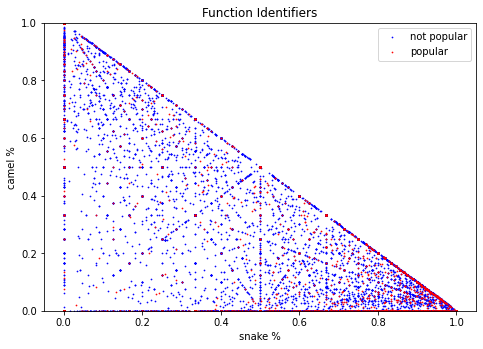

In [200]:
id_type = "func"
result = map(
    lambda _dict: [
        _dict["id"][id_type]["snake"],
        _dict["id"][id_type]["lower_camel"] + _dict["id"][id_type]["upper_camel"],
    ],
    plot_data_metrics,
)
X = np.array(list(result))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(
    X[non_pop_idx][:, 0], X[non_pop_idx][:, 1], 0.5, color="blue", label="not popular"
)
ax.scatter(X[pop_idx][:, 0], X[pop_idx][:, 1], 0.5, color="red", label="popular")
ax.legend()
ax.set_title(f"Function Identifiers")
ax.set_xlabel("snake %")
ax.set_ylabel("camel %")

plt.show()
fig.savefig(f"{id_type}_id.jpg", dpi=300,bbox_inches='tight')

In [188]:
plot_comment_dens = train_plot_df["comment_den"].to_numpy()

In [189]:
plot_doc_str_den = []
plot_line_counts = train_plot_df["line_count"].tolist()
for i in range(len(plot_data_metrics)):
    doc_str_line_count = plot_data_metrics[i]["doc_str"]["lines"]
    line_count = plot_line_counts[i]
    density = round(doc_str_line_count / line_count, 6) if line_count > 0 else 0
    plot_doc_str_den.append(density)
    
plot_doc_str_den = np.array(plot_doc_str_den)

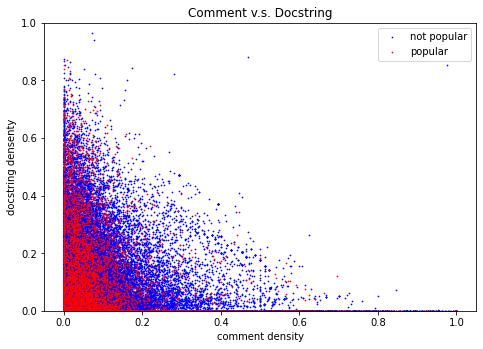

In [199]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylim([0, 1])

ax.scatter(
    plot_comment_dens[non_pop_idx], plot_doc_str_den[non_pop_idx], 0.5, color="blue", label="not popular"
)
ax.scatter(plot_comment_dens[pop_idx], plot_doc_str_den[pop_idx], 0.5, color="red", label="popular")
ax.legend()
ax.set_title("Comment v.s. Docstring")
ax.set_xlabel("comment density")
ax.set_ylabel("docstring densenty")

plt.show()
fig.savefig(f"comment_docstring.jpg", dpi=300,bbox_inches='tight')